In [1]:
import json

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import ipywidgets

from stellarpunk import util

# Loading and Preparing Data

In [2]:
df_base = pd.read_json("/tmp/stellarpunk_test.test_blocker_wall_collision_avoidance.history.gz", lines=True)
df_base = df_base.join(pd.json_normalize(df_base["o"]).add_prefix("o."))

In [3]:
eids = pd.Series(df_base["eid"].unique())
eids

0    2fe1c532-96a8-4eff-ad99-a8fae2517805
1    47bbe1e1-559d-4c7e-9b81-f8c719c9f5f4
2    7b6d5074-01d3-48ab-b178-10edd001ab7e
3    070e836e-dd58-41a8-aabf-4a12c21d6305
4    0763a6ea-b9d9-4e5f-bc98-d5d010dc578b
5    4424f5f4-2d2a-4cad-a7e6-2caca3811e6f
dtype: object

In [4]:
eids[pd.Series(df_base["eid"].unique()).str.startswith("1688")]

Series([], dtype: object)

In [5]:
target_eid = df_base["eid"].unique()[0]
df_base = df_base[df_base["eid"] == target_eid].reset_index()
df_base["eid"].unique()

array(['2fe1c532-96a8-4eff-ad99-a8fae2517805'], dtype=object)

In [6]:
loc = pd.DataFrame(np.vstack(df_base["loc"]), columns=["loc.x", "loc.y"])
v = pd.DataFrame(np.vstack(df_base["v"]), columns=["v.x", "v.y"])

empty_array = np.empty(len(df_base))
empty_array[:] = np.nan

if "o.t_loc" in df_base:
    o_tloc = pd.DataFrame(np.vstack(df_base["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_loc.x", "o.t_loc.y"])
    o_tv = pd.DataFrame(np.vstack(df_base["o.t_v"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.t_v.x", "o.t_v.y"])
else:
    o_tloc = pd.DataFrame({"o.t_loc": empty_array, "o.t_loc.x": empty_array, "o.t_loc.y": empty_array})
    o_tv = pd.DataFrame({"o.t_v": empty_array, "o.t_v.x": empty_array, "o.t_v.y": empty_array})
    
if "o.ct" in df_base:
    o_ctloc = pd.DataFrame(np.vstack(df_base["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_loc.x", "o.ct_loc.y"])
    o_ctdv = pd.DataFrame(np.vstack(df_base["o.ct_dv"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), columns=["o.ct_dv.x", "o.ct_dv.y"])
else:
    o_ctloc = pd.DataFrame({"o.ct_loc": empty_array, "o.ct_loc.x": empty_array, "o.ct_loc.y": empty_array})
    o_ctdv = pd.DataFrame({"o.ct_dv": empty_array, "o.ct_dv.x": empty_array, "o.ct_dv.y": empty_array})
angle = pd.DataFrame(np.vstack(df_base.apply(lambda row: np.array(util.polar_to_cartesian(100, row["a"])), axis=1)), columns=["angle.x", "angle.y"])
df = pd.concat([df_base, loc, v, o_ctloc, o_ctdv, o_tloc, o_tv, angle], axis=1)

if "o.ct" not in df_base:
    df["o.ct"] = empty_array
    df["o.ct_ts"] = empty_array
    df["o.cac"] = empty_array
    df["o.cbdr"] = empty_array
    
if "o.t_loc" not in df_base:
    df["o.cs"] = empty_array

In [7]:
df["speed"] = np.linalg.norm(df[["v.x", "v.y"]], axis=1)
df["o_ct_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.ct_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_dist"] = np.linalg.norm(np.vstack(df["loc"]) - np.vstack(df["o.t_loc"].apply(lambda x: (np.nan, np.nan) if np.all(np.isnan(x)) else x)), axis=1)
df["o_t_speed"] = np.linalg.norm(df[["o.t_v.x", "o.t_v.y"]], axis=1)
df["f_mag"] = df["f"].apply(lambda x:np.linalg.norm(x))

In [8]:
df["o_ct_v.x"] = (df["o.ct_loc.x"].shift(1) - df["o.ct_loc.x"]) / (df["ts"].shift(1) - df["ts"])
df["o_ct_v.y"] = (df["o.ct_loc.y"].shift(1) - df["o.ct_loc.y"]) / (df["ts"].shift(1) - df["ts"])

In [9]:
df

,index,eid,ts,loc,a,v,av,f,t,o,...,o.t_v.y,angle.x,angle.y,speed,o_ct_dist,o_t_dist,o_t_speed,f_mag,o_ct_v.x,o_ct_v.y
0,0,2fe1c532-96a8-4eff-ad99-a8fae2517805,0.000000,"[-400.0, 20000.0]",0.000000,"[0.0, 0.0]",0.000000,"[99.98000599799967, -4999.000299900035]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,-999.80006,100.000000,0.000000,0.000000e+00,NaN,20003.999600,1000.0,5000.000000,NaN,NaN
1,1,2fe1c532-96a8-4eff-ad99-a8fae2517805,0.016667,"[-400.0, 20000.0]",0.000000,"[0.0008331667166490001, -0.041658335832500004]",-0.016667,"[100.10415464412326, -4998.997815384899]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-999.80006,100.000000,0.000000,4.166667e-02,10000.499988,20003.999600,1000.0,5000.000000,NaN,NaN
2,2,2fe1c532-96a8-4eff-ad99-a8fae2517805,0.033333,"[-399.99998611388804, 19999.999305694404]",-0.000278,"[0.001667368005351, -0.083316650960707]",-0.033333,"[100.2282877565635, -4998.995328096776]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-999.80006,99.999996,-0.027778,8.333333e-02,10000.499293,20003.998906,1000.0,5000.000000,-0.0,-0.0
3,3,2fe1c532-96a8-4eff-ad99-a8fae2517805,0.050000,"[-399.9999583244213, 19999.997917083554]",-0.000833,"[0.0025026037366550004, -0.124974945361514]",-0.050000,"[100.35240535798197, -4998.992838036364]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-999.80006,99.999965,-0.083333,1.250000e-01,10000.497904,20003.997517,1000.0,5000.000000,-0.0,-0.0
4,4,2fe1c532-96a8-4eff-ad99-a8fae2517805,0.066667,"[-399.999916614359, 19999.9958341678]",-0.001667,"[0.0033388737813050003, -0.16663321901181702]",-0.066667,"[100.47650747105357, -4998.990345204361]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'ct':...",...,-999.80006,99.999861,-0.166667,1.666667e-01,10000.495821,20003.995433,1000.0,5000.000000,-0.0,-0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3027,3027,2fe1c532-96a8-4eff-ad99-a8fae2517805,50.450000,"[189.1370286720186, 981.2343083415199]",-4.724478,"[-2.56226461676176, -13.292912375059055]",0.174242,"[94635.08592513557, 490962.52454942244]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,0.00000,1.208886,99.992693,1.353760e+01,NaN,999.296544,0.0,500000.000000,NaN,NaN
3028,3028,2fe1c532-96a8-4eff-ad99-a8fae2517805,50.466667,"[189.09432426173925, 981.0127598019355]",-4.721574,"[-1.773638900718964, -9.201558003813869]",0.157576,"[94635.08592513569, 490962.52454942244]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,0.00000,0.918499,99.995782,9.370937e+00,NaN,999.070918,0.0,500000.000000,NaN,NaN
3029,3029,2fe1c532-96a8-4eff-ad99-a8fae2517805,50.483333,"[189.06476361339392, 980.859400501872]",-4.718948,"[-0.985013184676166, -5.110203632568682]",0.140909,"[94635.08592513557, 490962.52454942244]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,0.00000,0.655881,99.997849,5.204271e+00,NaN,998.914735,0.0,500000.000000,NaN,NaN
3030,3030,2fe1c532-96a8-4eff-ad99-a8fae2517805,50.500000,"[189.04834672698266, 980.7742304413291]",-4.716599,"[-0.19638746863337, -1.018849261323495]",0.124242,"[23566.496236004477, 122261.91135881947]",-900000.0,"{'o': 'stellarpunk.orders.GoToLocation', 'nnd'...",...,0.00000,0.421036,99.999114,1.037604e+00,NaN,998.827997,0.0,124512.468106,NaN,NaN


# Basic Ship Vitals

## Position and Heading

In [10]:
def plot_location_chart(max_time):
    sample = df[df["ts"] <= max_time].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"])#, scale=100)
    plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"])
    #center = (0,2500)
    #radius = 10000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

ipywidgets.interact(plot_location_chart, max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=50.51666666666508, continuous_update=False, description='max_time', ma…

<function __main__.plot_location_chart(max_time)>

In [11]:
df[["loc.x", "loc.y"]].describe()

,loc.x,loc.y
count,3032.000000,3032.000000
mean,319.692059,8752.765337
std,390.534259,6756.138823
min,-400.000000,980.757250
25%,123.296039,2061.191347
50%,305.796902,7337.490435
75%,682.426633,15060.346655
max,978.957672,20000.000000


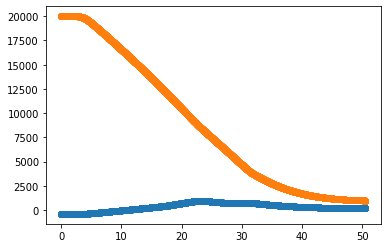

In [12]:
plt.scatter(df["ts"], df["loc.x"])
plt.scatter(df["ts"], df["loc.y"])

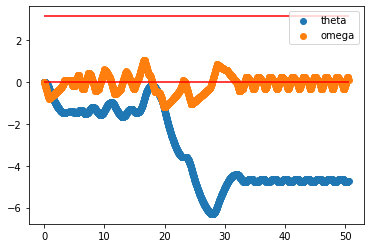

In [13]:
plt.scatter(df["ts"], df["a"], label="theta")
plt.scatter(df["ts"], df["av"], label="omega")
plt.hlines(np.pi, df["ts"].min(), df["ts"].max(), color="red")
plt.hlines(0, df["ts"].min(), df["ts"].max(), color="red")
plt.legend()

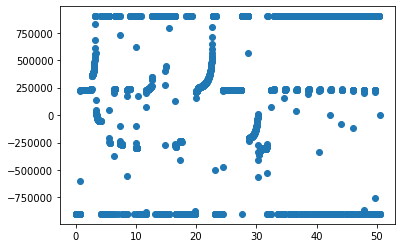

In [14]:
plt.scatter(df["ts"], df["t"])

## Velocity and Acceleration

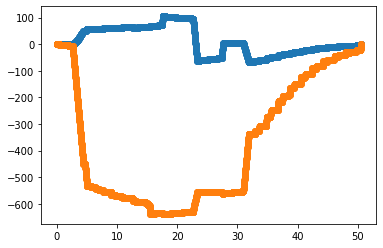

In [15]:
plt.scatter(df["ts"], df["v.x"])
plt.scatter(df["ts"], df["v.y"])

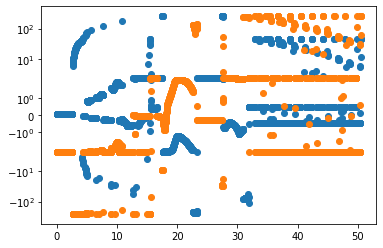

In [16]:
#plt.scatter(df["ts"], (df["v.x"] - df["v.x"].shift(-1)))#/(df["ts"]-df["ts"].shift(-1)))
plt.scatter(df["ts"], (df["v.x"].shift(1) - df["v.x"]) / (df["ts"].shift(1) - df["ts"]))
plt.scatter(df["ts"], (df["v.y"].shift(1) - df["v.y"]) / (df["ts"].shift(1) - df["ts"]))
plt.yscale("symlog")

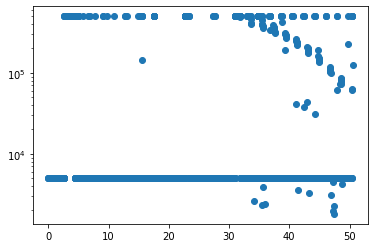

In [17]:
plt.scatter(df["ts"], df["f_mag"])
plt.yscale("log")

# Behavior Monitoring

In [18]:
def plot_collision_info(hist_length, max_time):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)]
    plt.scatter(sample["ts"], (~(sample["o.ct"].isna())).astype(int), label="ct")
    plt.scatter(sample["ts"], sample["o.cs"].fillna(0).astype(int)+0.05, label="cs")
    plt.scatter(sample["ts"], sample["o.cac"].fillna(0).astype(int)+0.1, label="cac")
    plt.scatter(sample["ts"], sample["o.cbdr"].fillna(0).astype(int)+0.15, label="cbdr")
    plt.legend()

ipywidgets.interact(plot_collision_info, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max()+.1, continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=50.516666…

<function __main__.plot_collision_info(hist_length, max_time)>

## Target Location

In [19]:
if np.any(~df["o.t_loc"].isna()):
    x = df.groupby(["o.t_loc.x", "o.t_loc.y"]).agg({"ts": ["count", "min", "max"], "o_t_dist": ["min","max"]})
else:
    x = "no location target"
x

ts               o_t_dist            
                    count  min   max         min         max
o.t_loc.x o.t_loc.y                                         
0.0       0.0        3031  0.0  50.5  998.827997  20003.9996

(998.8279974540095, 998.8279974540095)

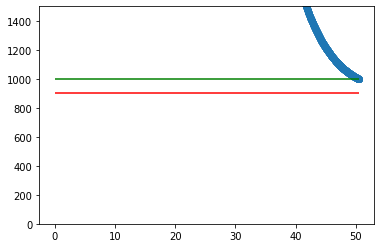

In [20]:
#sample = df[(df["ts"] < 124.4) & (df["ts"] > 120)]
sample = df
plt.scatter(sample["ts"], sample["o_t_dist"])
plt.hlines(1000, sample["ts"].min(), sample["ts"].max(), color="green")
plt.hlines(900, sample["ts"].min(), sample["ts"].max(), color="red")
plt.ylim(0,1500)
sample["o_t_dist"].min(),sample[df["ts"] > sample["ts"].max()-1]["o_t_dist"].min()

(0.0, 1050.0000000000002)

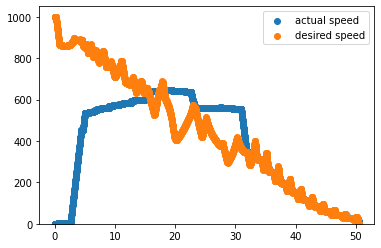

In [21]:
plt.scatter(df["ts"], df["speed"], label="actual speed")
plt.scatter(df["ts"], df["o_t_speed"], label="desired speed")
plt.legend()
plt.ylim(0)

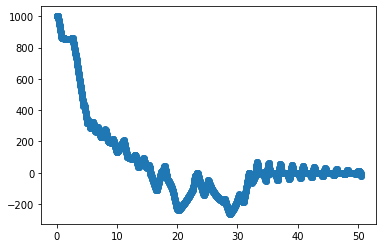

In [22]:
plt.scatter(df["ts"], df["o_t_speed"] - df["speed"])

## Collision Avoidance

In [23]:
if np.any(~df["o.ct"].isna()):
    x = df.groupby("o.ct").agg({"ts": ["count", "min", "max"], "o_ct_dist": ["min","max"]})
else:
    x = "no collision threats"
x

ts                          o_ct_dist  \
                                     count        min        max          min   
o.ct                                                                            
070e836e-dd58-41a8-aabf-4a12c21d6305   258  23.366667  27.650000  1032.677993   
0763a6ea-b9d9-4e5f-bc98-d5d010dc578b     2  23.350000  27.666667  4126.102201   
47bbe1e1-559d-4c7e-9b81-f8c719c9f5f4  1056   0.016667  17.600000  2152.682684   

                                                    
                                               max  
o.ct                                                
070e836e-dd58-41a8-aabf-4a12c21d6305   2706.215835  
0763a6ea-b9d9-4e5f-bc98-d5d010dc578b   6524.396318  
47bbe1e1-559d-4c7e-9b81-f8c719c9f5f4  10000.499988

1032.677993266002

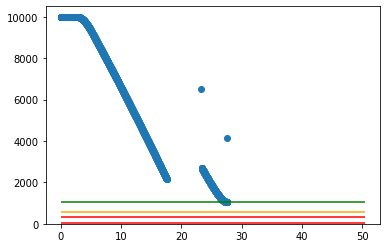

In [24]:
sample = df
plt.scatter(sample["ts"], sample["o_ct_dist"])
plt.hlines(60+500+500, sample["ts"].min(), sample["ts"].max(), color="green")
plt.hlines(60+500, sample["ts"].min(), sample["ts"].max(), color="orange")
plt.hlines(330, sample["ts"].min(), sample["ts"].max(), color="red")
plt.hlines(60, sample["ts"].min(), sample["ts"].max(), color="red")
plt.ylim(0)
df["o_ct_dist"].min()

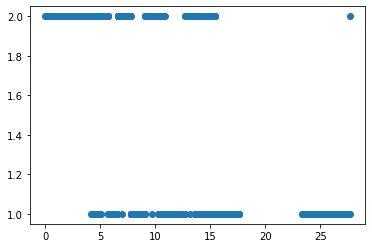

In [25]:
plt.scatter(df["ts"], df["o.ct_ct"])

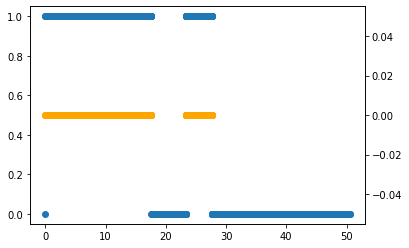

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.scatter(df["ts"], 1-df["o.ct"].isna().astype(int))
ax2.scatter(df["ts"], df["ts"] - df["o.ct_ts"], color="orange")

#ax2.set_ylim(0,(df["ts"] - df["o.ct_ts"]).max()*1.2)

# History Visualization

## Position and Velocity

In [27]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max(), sampling_interval=50, show_tloc=True):
    plt.figure(figsize=(10, 10))
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::sampling_interval]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["v.x"], sample["v.y"], label="v")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    
    plt.quiver(sample["o.ct_loc.x"], sample["o.ct_loc.y"], sample["o_ct_v.x"], sample["o_ct_v.y"])
    cmap = plt.get_cmap('viridis')
    for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(df["o.ct"].unique())))):
        if not isinstance(x, str):
            continue
        ct = sample[sample["o.ct"] == x]
        if len(ct) == 0:
            continue
        plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    
    if show_tloc:
        plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
        for (tloc_x, tloc_y) in sample.groupby(["o.t_loc.x", "o.t_loc.y"])["o.t_loc"].min():
            arrival_dist = plt.Circle((tloc_x, tloc_y), 1000, color="green", fill=False)
            min_dist = plt.Circle((tloc_x, tloc_y), 900, color="red", fill=False)
            plt.gca().add_patch(arrival_dist)
            plt.gca().add_patch(min_dist)
    plt.axis('equal')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.show()
    
ipywidgets.interact(
    plot_collision_chart,
    hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False),
    max_time=ipywidgets.FloatSlider(step=1/60, value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False),
    sampling_interval=ipywidgets.IntSlider(value=20, min=1, max=100, continuous_update=False),
    show_tloc=ipywidgets.Checkbox(value=True),
)

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=50.516666…

<function __main__.plot_collision_chart(hist_length=50.51666666666508, max_time=50.51666666666508, sampling_interval=50, show_tloc=True)>

## Position and Heading

In [28]:
def plot_collision_chart(hist_length=df["ts"].max(), max_time=df["ts"].max()):
    sample = df[(df["ts"] >= max_time - hist_length) & (df["ts"] <= max_time)].iloc[::50]
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["angle.x"], sample["angle.y"], label="ship")
    ctdv_df = sample[~(sample["o.ct_dv"].isna())]
    plt.quiver(ctdv_df["loc.x"], ctdv_df["loc.y"], ctdv_df["o.ct_dv.x"], ctdv_df["o.ct_dv.y"], label="ctdv", color="orange")
    plt.quiver(sample["loc.x"], sample["loc.y"], sample["o.t_v.x"], sample["o.t_v.y"], label="tv", color="purple")
    cmap = plt.get_cmap('viridis')
    #for x, c in zip(df["o.ct"].unique(), cmap(np.linspace(0, 1, len(sample["o.ct"].unique())))):
    #    print(x)
    #    if not isinstance(x, str):
    #        continue
    #    ct = sample[sample["o.ct"] == x]
    #    plt.scatter(ct["o.ct_loc.x"], ct["o.ct_loc.y"], color=c, label=x[:8])
    #plt.scatter(sample["o.t_loc.x"], sample["o.t_loc.y"], label="t_loc")
    #plt.axis('square')
    #center = (-33555, -5000)
    #radius = 15000
    #plt.xlim(center[0]-radius,center[0]+radius)
    #plt.ylim(center[1]-radius,center[1]+radius)

    plt.legend()
    plt.axis('equal')
    plt.show()
    
ipywidgets.interact(plot_collision_chart, hist_length=ipywidgets.FloatSlider(value=5, min=0, max=df["ts"].max()-df["ts"].min(), continuous_update=False), max_time=ipywidgets.FloatSlider(value=df["ts"].max(), min=df["ts"].min(), max=df["ts"].max(), continuous_update=False))

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='hist_length', max=50.516666…

<function __main__.plot_collision_chart(hist_length=50.51666666666508, max_time=50.51666666666508)>

# 